# [Texture Generation with Neural Cellular Automata](https://distill.pub/selforg/2021/textures) (PyTorch version)

This notebook contains a minimalistic PyTorch implementation of the Texture Nerual CA model. For pretrained models and other experiments please refer to the [TF2 version](https://colab.research.google.com/github/google-research/self-organising-systems/blob/master/notebooks/texture_nca_tf2.ipynb).

*Copyright 2021 Google LLC*

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

[https://www.apache.org/licenses/LICENSE-2.0](https://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

### Changelog

**2022-06-23**
  * Switched to sliced optmial transport VGG style loss
  * Fixed gradient checkpointing

In [ ]:
#@title Imports and Notebook Utilities
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

from IPython.display import Image, HTML, Markdown, clear_output
from tqdm import tqdm_notebook, tnrange

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    # wikimedia requires a user agent
    headers = {
      "User-Agent": "Requests in Colab/0.0 (https://colab.research.google.com/; no-reply@google.com) requests/0.0"
    }
    r = requests.get(url, headers=headers)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg', id=None):
  return display(Image(data=imencode(a, fmt)), display_id=id)

def grab_plot(close=True):
  """Return the current Matplotlib figure as an image"""
  fig = pl.gcf()
  fig.canvas.draw()
  img = np.array(fig.canvas.renderer._renderer)
  a = np.float32(img[..., 3:]/255.0)
  img = np.uint8(255*(1.0-a) + img[...,:3] * a)  # alpha
  if close:
    pl.close()
  return img

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))


class LoopWriter(VideoWriter):
  def __init__(self, *a, cross_len=1.0, **kw):
    super().__init__(*a, **kw)
    self._intro = []
    self._outro = []
    self.cross_len = int(cross_len*self.params['fps'])

  def add(self, img):
    if len(self._intro) < self.cross_len:
      self._intro.append(img)
      return
    self._outro.append(img)
    if len(self._outro) > self.cross_len:
      super().add(self._outro.pop(0))
  
  def close(self):
    for t in np.linspace(0, 1, len(self._intro)):
      img = self._intro.pop(0)*t + self._outro.pop(0)*(1.0-t)
      super().add(img)
    super().close()

!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-2e58775e-5421-78a5-a720-d4b7f2f85f29)


In [ ]:
import torch
import torchvision.models as models
import torch.nn.functional as F

torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [ ]:
#@title VGG16 Sliced OT Style Model
vgg16 = models.vgg16(weights='IMAGENET1K_V1').features

def calc_styles_vgg(imgs):
  style_layers = [1, 6, 11, 18, 25]  
  mean = torch.tensor([0.485, 0.456, 0.406])[:,None,None]
  std = torch.tensor([0.229, 0.224, 0.225])[:,None,None]
  x = (imgs-mean) / std
  b, c, h, w = x.shape
  features = [x.reshape(b, c, h*w)]
  for i, layer in enumerate(vgg16[:max(style_layers)+1]):
    x = layer(x)
    if i in style_layers:
      b, c, h, w = x.shape
      features.append(x.reshape(b, c, h*w))
  return features

def project_sort(x, proj):
  return torch.einsum('bcn,cp->bpn', x, proj).sort()[0]

def ot_loss(source, target, proj_n=32):
  ch, n = source.shape[-2:]
  projs = F.normalize(torch.randn(ch, proj_n), dim=0)
  source_proj = project_sort(source, projs)
  target_proj = project_sort(target, projs)
  target_interp = F.interpolate(target_proj, n, mode='nearest')
  return (source_proj-target_interp).square().sum()

def create_vgg_loss(target_img):
  yy = calc_styles_vgg(target_img)
  def loss_f(imgs):
    xx = calc_styles_vgg(imgs)
    return sum(ot_loss(x, y) for x, y in zip(xx, yy))
  return loss_f

def to_nchw(img):
  img = torch.as_tensor(img)
  if len(img.shape) == 3:
    img = img[None,...]
  return img.permute(0, 3, 1, 2)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
#@title Minimalistic Neural CA
ident = torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]])
sobel_x = torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])
lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])

def perchannel_conv(x, filters):
  '''filters: [filter_n, h, w]'''
  b, ch, h, w = x.shape
  y = x.reshape(b*ch, 1, h, w)
  y = torch.nn.functional.pad(y, [1, 1, 1, 1], 'circular')
  y = torch.nn.functional.conv2d(y, filters[:,None])
  return y.reshape(b, -1, h, w)

def perception(x):
  filters = torch.stack([ident, sobel_x, sobel_x.T, lap])
  return perchannel_conv(x, filters)

class CA(torch.nn.Module):
  def __init__(self, chn=12, hidden_n=96):
    super().__init__()
    self.chn = chn
    self.w1 = torch.nn.Conv2d(chn*4, hidden_n, 1)
    self.w2 = torch.nn.Conv2d(hidden_n, chn, 1, bias=False)
    self.w2.weight.data.zero_()

  def forward(self, x, update_rate=0.5):
    y = perception(x)
    y = self.w2(torch.relu(self.w1(y)))
    b, c, h, w = y.shape
    udpate_mask = (torch.rand(b, 1, h, w)+update_rate).floor()
    return x+y*udpate_mask

  def seed(self, n, sz=128):
    return torch.zeros(n, self.chn, sz, sz)

def to_rgb(x):
  return x[...,:3,:,:]+0.5

param_n = sum(p.numel() for p in CA().parameters())
print('CA param count:', param_n)

CA param count: 5856


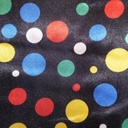

In [ ]:
#@title Target image {vertical-output: true}
url = 'https://www.robots.ox.ac.uk/~vgg/data/dtd/thumbs/dotted/dotted_0201.jpg'
style_img = imread(url, max_size=128)
with torch.no_grad():
  loss_f = create_vgg_loss(to_nchw(style_img))
imshow(style_img)

In [ ]:
#@title setup training
ca = CA() 
opt = torch.optim.Adam(ca.parameters(), 1e-3, capturable=True)
lr_sched = torch.optim.lr_scheduler.MultiStepLR(opt, [1000, 2000], 0.3)
loss_log = []
with torch.no_grad():
  pool = ca.seed(256)


        step_n: 4996
        loss: 102846.0078125
        lr: 8.999999999999999e-05

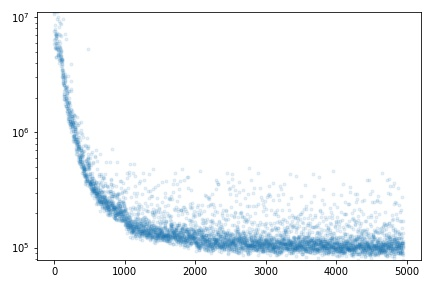

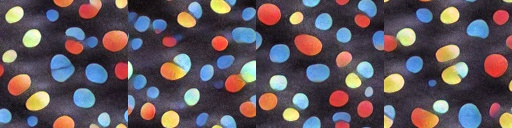

In [ ]:
#@title training loop {vertical-output: true}

gradient_checkpoints = False  # Set in case of OOM problems

for i in range(5000):
  with torch.no_grad():
    batch_idx = np.random.choice(len(pool), 4, replace=False)
    x = pool[batch_idx]
    if i%8 == 0:
      x[:1] = ca.seed(1)
  step_n = np.random.randint(32, 96)
  if not gradient_checkpoints:
    for k in range(step_n):
      x = ca(x)
  else:
    x.requires_grad = True  # https://github.com/pytorch/pytorch/issues/42812
    x = torch.utils.checkpoint.checkpoint_sequential([ca]*step_n, 16, x)

  overflow_loss = (x-x.clamp(-1.0, 1.0)).abs().sum()
  loss = loss_f(to_rgb(x))+overflow_loss
  with torch.no_grad():
    loss.backward()
    for p in ca.parameters():
      p.grad /= (p.grad.norm()+1e-8)   # normalize gradients 
    opt.step()
    opt.zero_grad()
    lr_sched.step()
    pool[batch_idx] = x                # update pool
    
    loss_log.append(loss.item())
    if i%5 == 0:
      display(Markdown(f'''
        step_n: {len(loss_log)}
        loss: {loss.item()}
        lr: {lr_sched.get_last_lr()[0]}'''), display_id='stats')
    if i%50==0:
      pl.plot(loss_log, '.', alpha=0.1)
      pl.yscale('log')
      pl.ylim(np.min(loss_log), loss_log[0])
      pl.tight_layout()
      imshow(grab_plot(), id='log')
      imgs = to_rgb(x).permute([0, 2, 3, 1]).cpu()
      imshow(np.hstack(imgs), id='batch')

In [ ]:
#@title NCA video {vertical-output: true}
with VideoWriter() as vid, torch.no_grad():
  x = ca.seed(1, 256)
  for k in tnrange(300, leave=False):
    step_n = min(2**(k//30), 8)
    for i in range(step_n):
      x[:] = ca(x)
    img = to_rgb(x[0]).permute(1, 2, 0).cpu()
    vid.add(zoom(img, 2))

  0%|          | 0/300 [00:00<?, ?it/s]